## Getting the Data

In [1]:
#Mount the Google Drive to Google Colab
#1. get the library
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#rooth_path directs the cd to the right folder in the Google Drive
root_path = '/content/gdrive/My Drive/ReDi_DA_Project/preprocessed_ga_revenue_data'

In [2]:
cd '/content/gdrive/My Drive/ReDi_DA_Project/preprocessed_ga_revenue_data'

/content/gdrive/My Drive/ReDi_DA_Project/preprocessed_ga_revenue_data


In [0]:
# download the libraries
import pandas as pd
from pandas import Series,DataFrame
import warnings
import os
warnings.filterwarnings('ignore')
#!pip3 install --upgrade seaborn cufflinks plotly
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import random
from pandas.io.json import json_normalize
%matplotlib inline

In [0]:
# load training data set info a df
df_train = pd.read_pickle('train_flat_no_hits.pkl')
#df_test = pd.read_pickle('test_flat_no_hits.pkl')

In [5]:
df_train.head()

channelGrouping      date  ... customDimension.index customDimension.value
0  Organic Search  20171016  ...                     4                  EMEA
1        Referral  20171016  ...                     4         North America
2          Direct  20171016  ...                     4         North America
3  Organic Search  20171016  ...                     4                  EMEA
4  Organic Search  20171016  ...                     4       Central America

[5 rows x 60 columns]

## Convert date columns

In [0]:
#convert date columns so that we can actually use it
df_train['date'] = pd.to_datetime(df_train["date"], format="%Y%m%d") #convert to datetime
df_train['year'] = df_train['date'].dt.year #for year
df_train['day'] = df_train.date.dt.day_name() #for day
df_train['week'] = df_train.date.dt.weekofyear #week
df_train['month'] = df_train.date.dt.month_name() #month

## Convert Objective Variable in a Number

In [0]:
df_train["totals.transactionRevenue"] = df_train["totals.transactionRevenue"].astype('float')

In [0]:
df_train["totals.transactionRevenue"] = df_train["totals.transactionRevenue"].fillna(0.0).astype(float)

In [0]:
print("Transaction Revenue Mean Value: ", df_train['totals.transactionRevenue'].mean())
print("Transaction Revenue median Value: ", df_train['totals.transactionRevenue'].median())

Transaction Revenue Mean Value:  1355906.3463473541
Transaction Revenue median Value:  0.0


We calculate the mean value and the median for the visitors that have made a succesfull purchase. 

In [0]:
print("Transaction Revenue Mean Value: ", 
      df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].mean()) # mean value of above 0
print("Transaction Revenue Median Value: ", 
      df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].median()) # median value of above 0

Transaction Revenue Mean Value:  125113156.53019337
Transaction Revenue Median Value:  46060000.0


## Checking for Missing Values

In [0]:
#checking missing values- sample
df_train.isnull().sum().sort_values(ascending = False)
#df_train.isna().sum().sort_values(ascending = False)

We start working with the whole data to grasp a better understanding about the missing data. To do that we define a function:

In [0]:
def values_missing(check):
    total = check.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (check.isnull().sum() / check.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df_train = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total and percent of missing values: ")
    print (df_train[~(df_train['Total'] == 0)]) # Returning values of nulls different of 0
    
    return

In [12]:
values_missing(df_train)

Total and percent of missing values: 
                                                Total    Percent
trafficSource.campaignCode                    1708336  99.999941
totals.totalTransactionRevenue                1689823  98.916256
totals.transactions                           1689778  98.913622
trafficSource.adContent                       1643600  96.210525
trafficSource.adwordsClickInfo.slot           1633063  95.593727
trafficSource.adwordsClickInfo.page           1633063  95.593727
trafficSource.adwordsClickInfo.isVideoAd      1633063  95.593727
trafficSource.adwordsClickInfo.adNetworkType  1633063  95.593727
trafficSource.adwordsClickInfo.gclId          1632914  95.585005
trafficSource.isTrueDirect                    1173819  68.711209
trafficSource.referralPath                    1142073  66.852910
trafficSource.keyword                         1052780  61.626014
totals.timeOnSite                              874294  51.178076
totals.bounces                                 83675

Before replacing the missing data, we check the columns with unique values. The assumption is that:                                                     
**Columns with 1 unique value for the whole group of records do not give any useful information for prediction porposes.**

In [13]:
unique_columns = [col for col in df_train.columns if df_train[col].nunique() == 1] #Columns with just one value

# print these columns and the name of columns 
print("numbers of columns: ", len(unique_columns), "columns with 1 value")
print("label of columns: \n", unique_columns)

numbers of columns:  25 columns with 1 value
label of columns: 
 ['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode', 'customDimension.index']


We found out that there are 25 columns with 1 value. We check the content in these  columns before decide if they are actually  useless.

In [0]:
# i define a function to show the columns ans a sample of the data
def see_data(data, data_type=object, limit=5): #seting the function with data,show 5 uniques if available 
    n = data.select_dtypes(include=data_type) #selecting the desired data type
    for column in n.columns: #initializing the loop
        print("______________________________________________________________")
        print("Name of column ", column, ': \n', "Uniques: ", data[column].unique()[:limit], "\n",
              " | ## Total nulls: ", (round(data[column].isnull().sum() / len(data[column]) * 100,2)),
              " | ## Total unique values: ", df_train.nunique()[column]) #print the data and % of nulls)
        print("_________________________________________________________")
        
      

In [0]:
#see_data(df_train)

This is a list with the  columns that are either: "not available in our dataset" or those that have unique values
 - Name of column  socialEngagementType : 
 Uniques:  ['Not Socially Engaged'] 
 
- device.browserVersion : 
 Uniques:  ['not available in demo dataset']

- device.operatingSystemVersion : 
 Uniques:  ['not available in demo dataset']
 
- Name of column  device.mobileDeviceBranding : 
 Uniques:  ['not available in demo dataset']
 
- Name of column  device.mobileDeviceBranding : 
 Uniques:  ['not available in demo dataset']
 
- Name of column  device.mobileDeviceModel : 
 Uniques:  ['not available in demo dataset']
 
- Name of column  device.mobileInputSelector : 
 Uniques:  ['not available in demo dataset'] 
 
- Name of column  device.mobileDeviceInfo : 
 Uniques:  ['not available in demo dataset'] 

- Name of column  device.mobileDeviceMarketingName : 
 Uniques:  ['not available in demo dataset']
 
- Name of column  device.flashVersion : 
 Uniques:  ['not available in demo dataset']  
 
- Name of column  device.language : 
 Uniques:  ['not available in demo dataset'] 

- Name of column  device.screenColors : 
 Uniques:  ['not available in demo dataset']

- Name of column  device.screenResolution : 
 Uniques:  ['not available in demo dataset']
 
- Name of column  geoNetwork.cityId : 
 Uniques:  ['not available in demo dataset'] 
 
- Name of column  geoNetwork.latitude : 
 Uniques:  ['not available in demo dataset']  

- Name of column  geoNetwork.longitude : 
 Uniques:  ['not available in demo dataset'] 

- Name of column  geoNetwork.networkLocation : 
 Uniques:  ['not available in demo dataset']

- Name of column  totals.visits : 
 Uniques:  ['1'] 
 
- Name of column  trafficSource.adwordsClickInfo.criteriaParameters : 
 Uniques:  ['not available in demo dataset'] 

'''
This is a list of other columns that contain values that might be useless for prediction:
- Name of column  trafficSource.adwordsClickInfo.gclId : 
 Uniques:  [nan'Cj0KCQjwsZHPBRClARIsAC-VMPBHdNF2oMOgh6Xp6YhjXWSk11sDu3eCo4De_u6l4xafqgrPVPSGYdkaArkiEALw_wcB''CODVoMjJ9tYCFUIvgQod_dsKEA''Cj0KCQjwsZHPBRClARIsAC-VMPA4CVJtDhu1lYkB0AR1hje1goUMHQZNJMrsSWD57pLnv1KE_L7pCEcaAunKEALw_wcB''Cj0KCQjwsZHPBRClARIsAC-VMPDlLD6kS4tmqFGZjMUqyerwe0WDaULaAKNkj-gwuvPnLSPRyf9TN7IaArICEALw_wcB'] 
- Name of column  trafficSource.adwordsClickInfo.page : 
 Uniques:  [nan '1' '3' '2' '5']
- Name of column  trafficSource.referralPath : 
 Uniques:  [nan '/a/google.com/transportation/mtv-services/bikes/bike2workmay2016''/offer/2145' '/a/google.com/nest-vision/dropcam-field-tester-program''/analytics/web/'] 
- Name of column  trafficSource.campaign : 
 Uniques:  ['(not set)' '"google + redesign/Accessories March 17" All Users''AW - Dynamic Search Ads Whole Site' '1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS' 'Data Share Promo'] 
- Name of column  trafficSource.adwordsClickInfo.slot : 
 Uniques:  [nan 'Top' 'RHS' 'Google Display Network']
 
- Name of column  trafficSource.adContent : 
 Uniques:  [nan 'Placement Accessories 300 x 250' 'Google Merchandise Store''Bags 300x250' 'Display Ad created 3/11/14']  
- Name of column  trafficSource.campaignCode : 
 Uniques:  [nan '11251kjhkvahf']   

'''

### Columns to Drop

After examining the values, These are the droped Columns:

In [0]:
drop_col_list = ['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion',
                 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 
                 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 
                 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 
                 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'trafficSource.campaign', 'trafficSource.referralPath', 
                 'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot', 
                 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.gclId', 
                 'trafficSource.campaignCode', 'customDimension.index']

In [0]:
df_train.drop(drop_col_list, axis=1, inplace=True)  #to drop them

Now we have 38 columns and we can see how many unique values there are on each of these columns.

In [0]:
df_train.nunique()

channelGrouping                                       8
date                                                638
fullVisitorId                                   1323730
visitId                                         1665802
visitNumber                                         457
visitStartTime                                  1667423
device.browser                                      129
device.operatingSystem                               24
device.isMobile                                       2
device.deviceCategory                                 3
geoNetwork.continent                                  6
geoNetwork.subContinent                              23
geoNetwork.country                                  228
geoNetwork.region                                   483
geoNetwork.metro                                    123
geoNetwork.city                                     956
geoNetwork.networkDomain                          41982
totals.visits                                   

These columns also have a lonely unique value, however these unique value is not applied to all the records in the column, therefore these columns might bring information as  dummie variables.
- totals.visits
- totals.bounces
- totals.newVisits
- trafficSource.isTrueDirect
- trafficSource.adwordsClickInfo.isVideoAd

### Missing Values

Afer dropping useless columns, we start cleaning and filling missing data for the remaining columns

In [0]:
#to check our data type again
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 38 columns):
 #   Column                                        Dtype         
---  ------                                        -----         
 0   channelGrouping                               object        
 1   date                                          datetime64[ns]
 2   fullVisitorId                                 object        
 3   visitId                                       int64         
 4   visitNumber                                   int64         
 5   visitStartTime                                int64         
 6   device.browser                                object        
 7   device.operatingSystem                        object        
 8   device.isMobile                               bool          
 9   device.deviceCategory                         object        
 10  geoNetwork.continent                          object        
 11  geoNetwork.subContinent 

From the previous analysis, we observe that the columns with number_values are in `string` format. 
We should convert them to numeric values as `int64` or `float` for our analysis and predictions.

these columns are objects. 
- totals.visits `object`       
- totals.hits `object`
- totals.pageviews `object` 
- totals.bounces `object`
- totals.newVisits `object`
- totals.sessionQualityDim `object`
- totals.timeOnSite `object`
- totals.transactions `object`
- totals.transactionRevenue `object`
- totals.totalTransactionRevenue `object`



### Filling Null Values

In [0]:
# can be infered from totals.transactionRevenue

df_train['totals.pageviews'].fillna(1, inplace=True) #filling NA's with 1(since least for a visit to the site means 1 page seen)
df_train['totals.newVisits'].fillna(0, inplace=True) #filling NA's with 0(0 is suitable for Nan here)
df_train['totals.bounces'].fillna(0, inplace=True)   #filling NA's with 0(0 is suitable for Nan here)
df_train["totals.transactionRevenue"] = df_train["totals.transactionRevenue"].fillna(0.0).astype(float) #filling NA with zero


In [0]:
#To convert

df_train['totals.pageviews'] = df_train['totals.pageviews'].astype(int) # setting numerical column as integer
df_train['totals.newVisits'] = df_train['totals.newVisits'].astype(int) # setting numerical column as integer
df_train['totals.bounces'] = df_train['totals.bounces'].astype(int)  # setting numerical column as integer
df_train["totals.hits"] = df_train["totals.hits"].astype(float) # setting numerical to float
df_train['totals.visits'] = df_train['totals.visits'].astype(int) # seting as int

We cannot decide on `totals.sessionQualityDim`,`totals.timeOnSite`.

But it seems like  `totals.transactions` and `totals.totalTransactionRevenue` can be infered from `totals.transactionRevenue`



In [21]:
#Check again the data
values_missing(df_train)

Total and percent of missing values: 
                                                Total    Percent
totals.totalTransactionRevenue                1689823  98.916256
totals.transactions                           1689778  98.913622
trafficSource.adwordsClickInfo.isVideoAd      1633063  95.593727
trafficSource.adwordsClickInfo.adNetworkType  1633063  95.593727
trafficSource.isTrueDirect                    1173819  68.711209
trafficSource.keyword                         1052780  61.626014
totals.timeOnSite                              874294  51.178076
totals.sessionQualityDim                       835274  48.893983
customDimension.value                          333235  19.506397


In [0]:
# leave them for now and revisit them if need it.

I paused here to focus on the ML pipeline. 
So far i have clean 80% of the dataset except for :

Total and percent of missing values: 
                                                **Total**    **Percent**
                                                
totals.totalTransactionRevenue                1689823  98.916256

totals.transactions                           1689778  98.913622

trafficSource.adwordsClickInfo.isVideoAd      1633063  95.593727

trafficSource.adwordsClickInfo.adNetworkType  1633063  95.593727

trafficSource.isTrueDirect                    1173819  68.711209

trafficSource.keyword                         1052780  61.626014

totals.timeOnSite                              874294  51.178076

totals.sessionQualityDim                       835274  48.893983

customDimension.value                          333235  19.506397

I will convert and fill trafficSource.adwordsClickInfo.isVideoAd and trafficSource.isTrueDirect
 i will drop trafficSource.adwordsClickInfo.adNetworkType,totals.timeOnSite,totals.sessionQualityDim and customDimension.value
 becasue they i can find similar values on other columns or i simply can't find a use for them or what to fill them with


 

In [0]:
    df_train['trafficSource.isTrueDirect'].fillna(False, inplace=True) # filling boolean with False is its NAn
    df_train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean is its NAn

In [0]:
new_drop_col_list = ['trafficSource.adwordsClickInfo.adNetworkType','totals.timeOnSite','totals.sessionQualityDim',
                 'customDimension.value','trafficSource.keyword']

In [0]:
df_train.drop(new_drop_col_list, axis=1, inplace=True)  #to drop them

In [0]:
df_train.head()

channelGrouping       date        fullVisitorId     visitId  visitNumber  \
0  Organic Search 2017-10-16  3162355547410993243  1508198450            1   
1        Referral 2017-10-16  8934116514970143966  1508176307            6   
2          Direct 2017-10-16  7992466427990357681  1508201613            1   
3  Organic Search 2017-10-16  9075655783635761930  1508169851            1   
4  Organic Search 2017-10-16  6960673291025684308  1508190552            1   

   visitStartTime device.browser device.operatingSystem  device.isMobile  \
0      1508198450        Firefox                Windows            False   
1      1508176307         Chrome              Chrome OS            False   
2      1508201613         Chrome                Android             True   
3      1508169851         Chrome                Windows            False   
4      1508190552         Chrome                Windows            False   

  device.deviceCategory  ... totals.transactionRevenue  \
0               desktop  ...                       0.0   
1               desktop  ...                       0.0   
2                mobile  ...                       0.0   
3               desktop  ...                       0.0   
4               desktop  ...                       0.0   

  totals.totalTransactionRevenue trafficSource.source trafficSource.medium  \
0                            NaN               google              organic   
1                            NaN     sites.google.com             referral   
2                            NaN             (direct)               (none)   
3                            NaN               google              organic   
4                            NaN               google              organic   

  trafficSource.isTrueDirect trafficSource.adwordsClickInfo.isVideoAd  year  \
0                      False                                     True  2017   
1                      False                                     True  2017   
2                       True                                     True  2017   
3                      False                                     True  2017   
4                      False                                     True  2017   

      day  week    month  
0  Monday    42  October  
1  Monday    42  October  
2  Monday    42  October  
3  Monday    42  October  
4  Monday    42  October  

[5 rows x 33 columns]

In [0]:
values_missing(df_train)

Total and percent of missing values: 
                                  Total    Percent
totals.totalTransactionRevenue  1689823  98.916256
totals.transactions             1689778  98.913622


I still cannot decide on this 2 columns, what do i do with them. I know the totals.totalTransactionRevenue seems same with the target , i think ii will remove it to aviod overfitiing
I aslo think i will fill totals.transactions with bcos if there was a value the number would have been available.

In [0]:
df_train["totals.transactions"] = df_train["totals.transactions"].fillna(0).astype(int)

In [0]:
df_train.drop('totals.totalTransactionRevenue',axis=1, inplace=True)

In [0]:
df_train.isna().sum()

channelGrouping                             0
date                                        0
fullVisitorId                               0
visitId                                     0
visitNumber                                 0
visitStartTime                              0
device.browser                              0
device.operatingSystem                      0
device.isMobile                             0
device.deviceCategory                       0
geoNetwork.continent                        0
geoNetwork.subContinent                     0
geoNetwork.country                          0
geoNetwork.region                           0
geoNetwork.metro                            0
geoNetwork.city                             0
geoNetwork.networkDomain                    0
totals.visits                               0
totals.hits                                 0
totals.pageviews                            0
totals.bounces                              0
totals.newVisits                  

In [0]:
df_train.isnull().sum()

channelGrouping                             0
date                                        0
fullVisitorId                               0
visitId                                     0
visitNumber                                 0
visitStartTime                              0
device.browser                              0
device.operatingSystem                      0
device.isMobile                             0
device.deviceCategory                       0
geoNetwork.continent                        0
geoNetwork.subContinent                     0
geoNetwork.country                          0
geoNetwork.region                           0
geoNetwork.metro                            0
geoNetwork.city                             0
geoNetwork.networkDomain                    0
totals.visits                               0
totals.hits                                 0
totals.pageviews                            0
totals.bounces                              0
totals.newVisits                  

OK now my data is clean. i will save the data set before i process with feature selection.

In [0]:
Cleaned_train = df_train

In [0]:
Cleaned_train.head()

channelGrouping       date        fullVisitorId     visitId  visitNumber  \
0  Organic Search 2017-10-16  3162355547410993243  1508198450            1   
1        Referral 2017-10-16  8934116514970143966  1508176307            6   
2          Direct 2017-10-16  7992466427990357681  1508201613            1   
3  Organic Search 2017-10-16  9075655783635761930  1508169851            1   
4  Organic Search 2017-10-16  6960673291025684308  1508190552            1   

   visitStartTime device.browser device.operatingSystem  device.isMobile  \
0      1508198450        Firefox                Windows            False   
1      1508176307         Chrome              Chrome OS            False   
2      1508201613         Chrome                Android             True   
3      1508169851         Chrome                Windows            False   
4      1508190552         Chrome                Windows            False   

  device.deviceCategory  ... totals.transactions totals.transactionRevenue  \
0               desktop  ...                   0                       0.0   
1               desktop  ...                   0                       0.0   
2                mobile  ...                   0                       0.0   
3               desktop  ...                   0                       0.0   
4               desktop  ...                   0                       0.0   

  trafficSource.source trafficSource.medium trafficSource.isTrueDirect  \
0               google              organic                      False   
1     sites.google.com             referral                      False   
2             (direct)               (none)                       True   
3               google              organic                      False   
4               google              organic                      False   

  trafficSource.adwordsClickInfo.isVideoAd  year     day  week    month  
0                                     True  2017  Monday    42  October  
1                                     True  2017  Monday    42  October  
2                                     True  2017  Monday    42  October  
3                                     True  2017  Monday    42  October  
4                                     True  2017  Monday    42  October  

[5 rows x 32 columns]

In [0]:
Cleaned_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 32 columns):
 #   Column                                    Dtype         
---  ------                                    -----         
 0   channelGrouping                           object        
 1   date                                      datetime64[ns]
 2   fullVisitorId                             object        
 3   visitId                                   int64         
 4   visitNumber                               int64         
 5   visitStartTime                            int64         
 6   device.browser                            object        
 7   device.operatingSystem                    object        
 8   device.isMobile                           bool          
 9   device.deviceCategory                     object        
 10  geoNetwork.continent                      object        
 11  geoNetwork.subContinent                   object        
 12  geoNetwork.cou

In [0]:
Cleaned_train.to_csv('/Users/chris/Desktop/chris_files.csv/Cleaned_train.csv',index=False)

NOW TO FEATURES SELECTION::::

using corellation matrix- heatmap

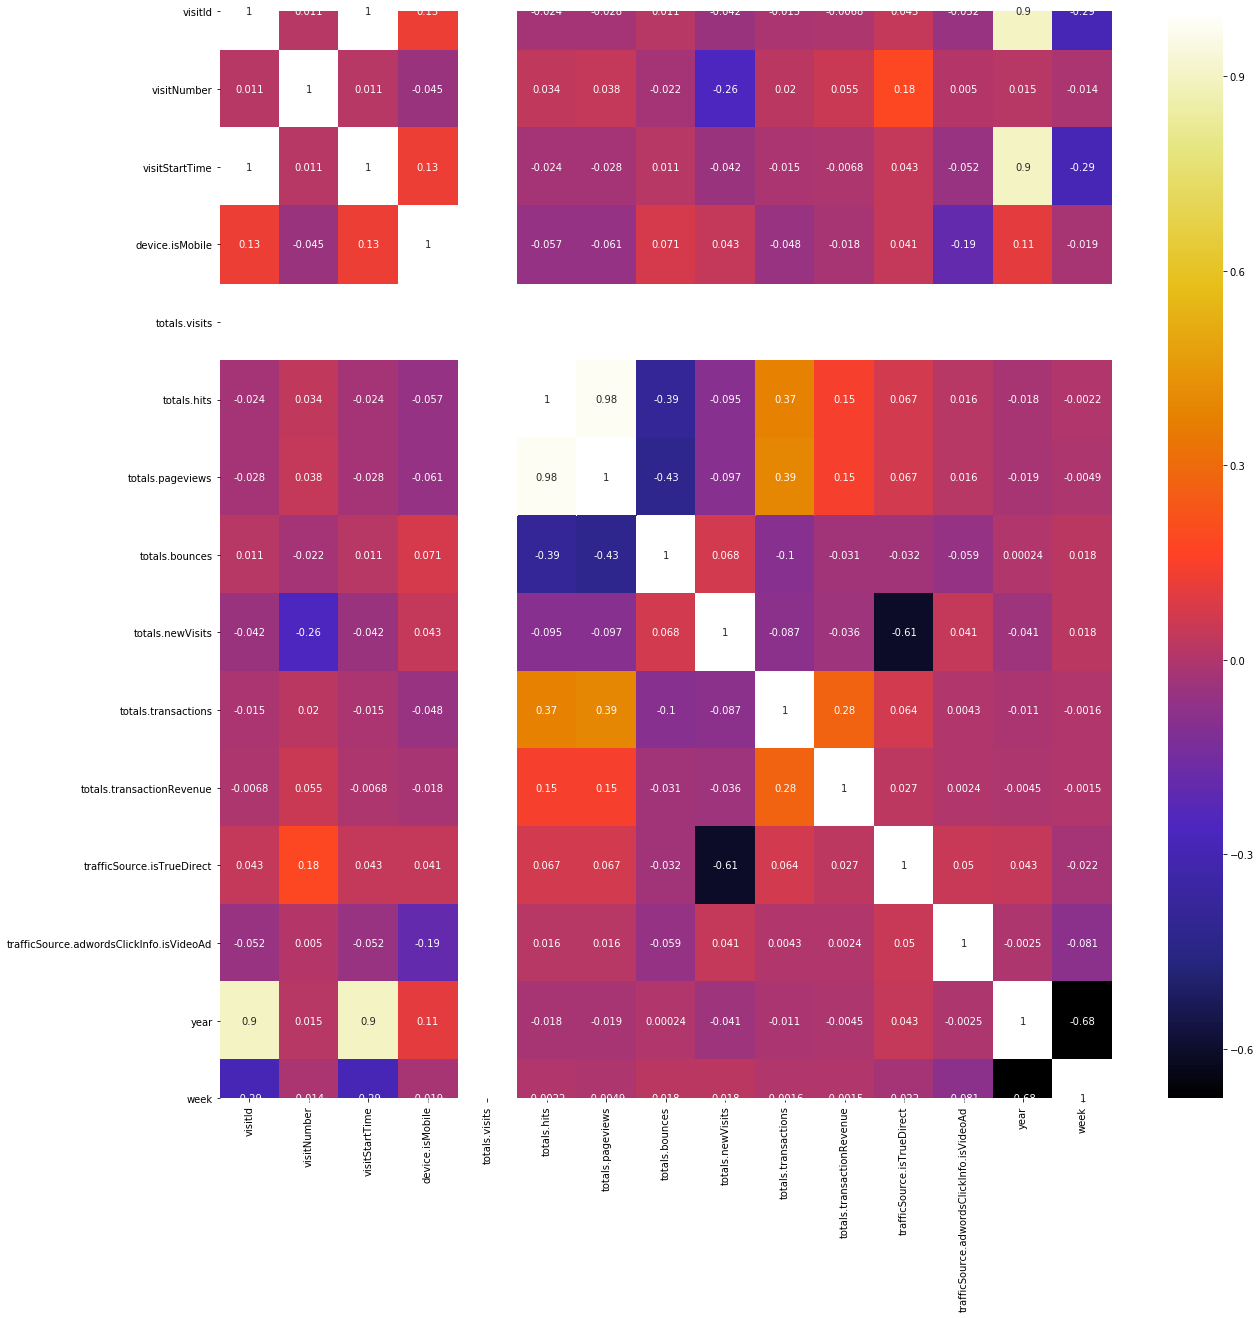

In [0]:
corrmat = Cleaned_train.corr()
top_corr_feature = corrmat.index

plt.figure(figsize = (20,20))
#plot heatmap

sns.heatmap(df_train[top_corr_feature].corr(),annot =True,cmap='CMRmap')


please interprete.........................................